In [657]:
import ipywidgets as widgets
import sys
from pathlib import Path
import os
import importlib


module_path='preprocessing/day_intervals_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)

module_path='utils'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='preprocessing/hosp_module_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='model'
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)
root_dir = os.path.dirname(os.path.abspath('UserInterface.ipynb'))
data_dir = '/datasets/MIMIC-IV/physionet.org/files'
import day_intervals_cohort
from day_intervals_cohort import *

import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

import data_generation_icu

import data_generation
import evaluation

import feature_selection_hosp
from feature_selection_hosp import *

# import train
# from train import *


import ml_models
from ml_models import *

import dl_train
from dl_train import *

import tokenization
from tokenization import *


import behrt_train
from behrt_train import *

import feature_selection_icu
from feature_selection_icu import *
import fairness
import callibrate_output

In [658]:
%load_ext autoreload
%autoreload 2

importlib.reload(day_intervals_cohort)
import day_intervals_cohort
from day_intervals_cohort import *

importlib.reload(day_intervals_cohort_v2)
import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

importlib.reload(data_generation_icu)
import data_generation_icu
importlib.reload(data_generation)
import data_generation

importlib.reload(feature_selection_hosp)
import feature_selection_hosp
from feature_selection_hosp import *

importlib.reload(feature_selection_icu)
import feature_selection_icu
from feature_selection_icu import *

importlib.reload(tokenization)
import tokenization
from tokenization import *

importlib.reload(ml_models)
import ml_models
from ml_models import *

importlib.reload(dl_train)
import dl_train
from dl_train import *

importlib.reload(behrt_train)
import behrt_train
from behrt_train import *

importlib.reload(fairness)
import fairness

importlib.reload(callibrate_output)
import callibrate_output

importlib.reload(evaluation)
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [659]:
def set_seed(seed):
    """set random seed."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Welcome to your MIMIC-IV Project

## 10. Running BEHRT
Below we integrate the implementation of BEHRT in our pipeline.
We perform pre-procesing needed to run BEHRT model. https://github.com/deepmedicine/BEHRT

Few things to note before running BEHRT -
- The numerical values are binned into quantiles.
- BEHRT has recommended maximum number of events per sample to be 512. 
    So feature selection is important so that number of events per sample does not exceed 512.
- The model is quite computationally heavy so it requires a GPU.

The output files for BEHRT will be saved in ./data/behrt/ folder

**Please run below cell to to pre-process and run BEHRT on the selected cohort**

In [682]:
importlib.reload(tokenization)
import tokenization
from tokenization import *

import behrt_train
from behrt_train import *

In [683]:
data_icu = True
diag_flag = True
proc_flag = False
out_flag = False
chart_flag = True
med_flag = True

In [684]:
if data_icu:
    token=tokenization.BEHRT_models(data_icu,diag_flag,proc_flag,out_flag,chart_flag,med_flag,False)
    #tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds, meds_labels, n_meds =token.tokenize()
    #data2_dir = '/datasets/MIMIC-IV/'
    data2_dir = '/h/chloexq/los-prediction/pipeline/data/features/'
    n_meds = 259
    names = ['tokenized_src', 'tokenized_age', 'tokenized_gender', 'tokenized_ethni', 'tokenized_ins', 'tokenized_labels', 'labs', 'meds']
    #meds_labels = np.load(data2_dir + 'data/token/'+'meds_labels_5000.npy', allow_pickle=True)
    meds_labels = np.load(data2_dir + 'meds_labels_5000.npy', allow_pickle=True)
    all_df = []
    for i in range(len(names)):
        #df = pd.read_csv(data2_dir + 'data/token/'+names[i]+'_5000.csv', index_col=0)
        df = pd.read_csv(data2_dir + names[i]+'_5000.csv', index_col=0)
        all_df.append(df)
    tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds = all_df

In [712]:
model_config = {
    'vocab_size': int(tokenized_src.max().max() + 1), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': int(tokenized_age.max().max() + 1), # number of vocab for age embedding
    'gender_vocab_size': 2 + 1, # TODO: +1 for missing values
    'ethni_vocab_size': int(tokenized_ethni.max().max()) + 1,
    'ins_vocab_size': int(tokenized_ins.max().max()) + 1,
    'max_position_embedding': tokenized_src.shape[1], # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 6, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 256, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'number_output' : 1,
    'number_meds': n_meds,
}

In [713]:
conf = BertConfig(model_config)
behrt = BertForEHRPrediction(conf, model_config['number_output'], setting='confuse')
device = "cuda:0" if torch.cuda.is_available() else "cpu"
behrt.load_state_dict(torch.load("./saved_models/checkpoint/DAB_confuse_oversample/behrt", map_location=device))

<All keys matched successfully>

In [714]:
behrt

BertForEHRPrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(2326, 288)
      (segment_embeddings): Embedding(2, 288)
      (age_embeddings): Embedding(93, 288)
      (gender_embeddings): Embedding(3, 288)
      (ethnicity_embeddings): Embedding(34, 288)
      (ins_embeddings): Embedding(4, 288)
      (posi_embeddings): Embedding(512, 288)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=288, out_features=288, bias=True)
              (key): Linear(in_features=288, out_features=288, bias=True)
              (value): Linear(in_features=288, out_features=288, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(

In [715]:
with open('./data/dict/condVocab.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

In [716]:
mask = ['_' in i for i in list(vocab_dict['token2idx'].keys())]

In [717]:
dyn_feature_keys = np.array(list(vocab_dict['token2idx'].keys()))[mask]

In [718]:
feature_df = pd.read_csv('dynamic_item_dict_short_263.csv')

In [719]:
feature_df

,itemid,type,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,221749.0,MEDS,Phenylephrine,Phenylephrine,inputevents,Medications,mg,Solution,NaN,NaN
1,222168.0,MEDS,Propofol,Propofol,inputevents,Medications,mg,Solution,NaN,NaN
2,221906.0,MEDS,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,NaN,NaN
3,225942.0,MEDS,Fentanyl (Concentrate),Fentanyl (Concentrate),inputevents,Medications,mg,Solution,NaN,NaN
4,222056.0,MEDS,Nitroglycerin,Nitroglycerin,inputevents,Medications,mg,Solution,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
258,227452.0,CHART,Tobramycin (Trough),Tobramycin (Trough),chartevents,Labs,None,Numeric with tag,NaN,NaN
259,227448.0,CHART,Gentamicin (Peak),Gentamicin (Peak),chartevents,Labs,None,Numeric with tag,NaN,NaN
260,227450.0,CHART,Tobramycin (Peak),Tobramycin (Peak),chartevents,Labs,None,Numeric with tag,NaN,NaN
261,227453.0,CHART,Vancomycin (Peak),Vancomycin (Peak),chartevents,Labs,None,Numeric with tag,NaN,NaN


In [720]:
dyn_feature_keys

array(['2_2', '231_0', '24_3', '106_1', '164_1', '58_3', '194_0', '240_1',
       '84_2', '190_3', '87_3', '4_1', '220_3', '242_3', '90_1', '179_2',
       '184_2', '244_0', '248_0', '19_1', '167_2', '84_1', '43_3', '0_3',
       '100_0', '134_0', '51_1', '17_3', '205_2', '232_3', '242_0',
       '79_0', '248_1', '26_3', '109_1', 'dyn_49', '70_2', '32_3', '82_0',
       '175_3', '215_2', '202_2', '241_3', '0_1', '14_2', '19_0', '190_2',
       '227_3', '238_3', '203_3', '8_3', '250_3', '163_2', '204_1',
       '242_2', '110_0', '117_2', '111_3', '25_0', '184_3', '142_2',
       '12_0', '28_2', '15_2', '122_2', '227_1', '87_1', '139_2', '141_3',
       '98_3', '206_1', '143_2', '74_2', '135_2', '181_2', '1_0', '256_0',
       '172_2', '258_2', '217_2', '236_2', '14_1', '35_2', '109_3',
       '248_3', '166_2', '126_3', '189_1', '204_2', '38_1', '12_2',
       '100_1', '75_2', '63_1', '232_2', '58_2', '241_0', '18_3', '50_0',
       '9_0', '253_1', '143_0', '231_1', '241_1', '183_1', '6_

In [721]:
ind = []
level = []
for i in dyn_feature_keys:
    i_0, i_1 = i.split('_')
    if i_0 == 'dyn':
        ind.append(int(i_1))
        level.append(-1)
    else:
        ind.append(int(i_0))
        level.append(int(i_1))

In [722]:
names = [feature_df.iloc[i, 2] for i in ind]
type = [feature_df.iloc[i, 5] for i in ind]

In [723]:
emb_id = [vocab_dict['token2idx'][i] for i in dyn_feature_keys]

In [724]:
df_key = pd.DataFrame()
df_key['df_id'] = ind
df_key['level'] = level
df_key['feature'] = names
df_key['emb_id'] = emb_id
df_key['type'] = type

In [725]:
df_key

,df_id,level,feature,emb_id,type
0,2,2,Norepinephrine,1359,Medications
1,231,0,T High (APRV),1360,Respiratory
2,24,3,Epinephrine,1361,Medications
3,106,1,Arterial O2 pressure,1362,Labs
4,164,1,Absolute Count - Monos,1363,Labs
...,...,...,...,...,...
962,213,1,Digoxin,2321,Labs
963,252,3,Peak Exp Flow Rate,2322,Respiratory
964,233,0,Negative Insp. Force,2323,Respiratory
965,53,0,Hydromorphone (Dilaudid),2324,Medications


In [726]:
meds_embs = behrt.bert.embeddings.word_embeddings.weight.data[df_key['emb_id'].values, :].numpy()
meds_embs.shape

(967, 288)

In [727]:
import umap
import seaborn as sns

In [728]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(meds_embs)

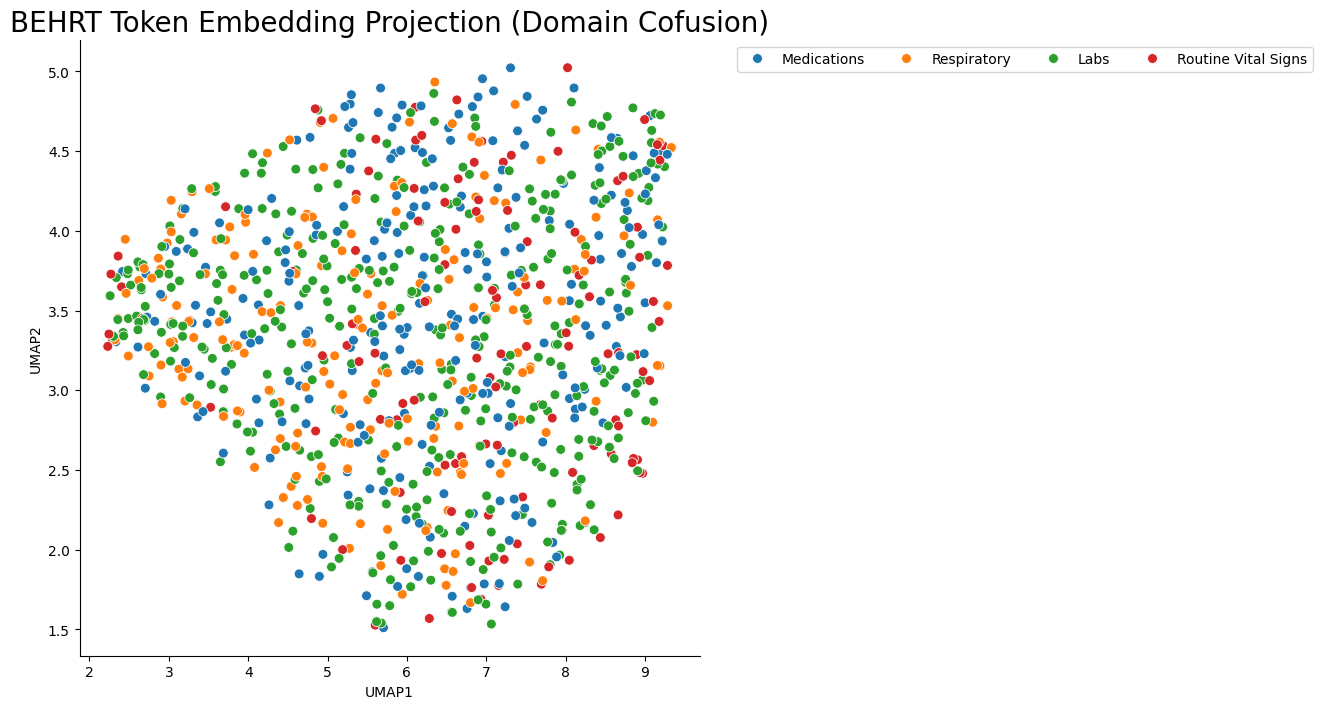

In [730]:
plt.figure(figsize=(8,8))
df = pd.DataFrame(X_umap, columns = ['x', 'y'])
df['label'] = df_key['type'].astype(str)
scatter = sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'label', s = 50)
plt.title('BEHRT Token Embedding Projection (Domain Cofusion)', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 10)
plt.ylabel("UMAP2", fontsize = 10)
scatter.spines['top'].set_visible(False)
scatter.spines['right'].set_visible(False)
scatter.legend(loc='upper right', bbox_to_anchor=(2, 1), ncol=4)
plt.show()

In [25]:
import faiss

In [26]:
faiss_index = faiss.IndexFlatL2(meds_embs.shape[1])
faiss_index.add(meds_embs)
D, I = faiss_index.search(meds_embs, 6)

In [27]:
columns = ['nn_'+str(i) for i in range(6)]
df_nn = pd.DataFrame(I, columns = columns)

In [28]:
df_nn = df_nn.replace(dict(zip(df_key.index.tolist(), df_key.feature.tolist())))

In [29]:
df_all = pd.concat((df_key, df_nn), axis=1)

In [30]:
df_all

,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
0,2,2,Norepinephrine,1359,Medications,Norepinephrine,Creatinine (whole blood),Respiratory Rate,Nicardipine,Mannitol,P High (APRV)
1,231,0,T High (APRV),1360,Respiratory,T High (APRV),Tobramycin (Peak),Calcium Gluconate (Bolus),Orthostatic HR lying,Vancomycin (Random),Sodium (serum)
2,24,3,Epinephrine,1361,Medications,Epinephrine,Absolute Count - Monos,Creatinine (serum),Digoxin,Cisatracurium,Calcium Chloride
3,106,1,Arterial O2 pressure,1362,Labs,Arterial O2 pressure,Plateau Pressure,Lactic Acid,Clevidipine (Cleviprex),PO2 (Mixed Venous),Differential-Lymphs
4,164,1,Absolute Count - Monos,1363,Labs,Absolute Count - Monos,Amylase,Esmolol,Dopamine,Triglyceride,RCexp (Measured Time Constant)
...,...,...,...,...,...,...,...,...,...,...,...
962,213,1,Digoxin,2321,Labs,Digoxin,Creatinine (whole blood),TCO2 (calc) Venous,D-Dimer,Arterial CO2 Pressure,O2 Flow
963,252,3,Peak Exp Flow Rate,2322,Respiratory,Peak Exp Flow Rate,Calcium Gluconate (Bolus),Vital Cap,Heparin Sodium (Impella),Respiratory Rate (Total),Calcium Chloride
964,233,0,Negative Insp. Force,2323,Respiratory,Negative Insp. Force,Phenylephrine (50/250),Orthostatic BPd standing,Diltiazem,Glucose (whole blood),Calcium Gluconate (Bolus)
965,53,0,Hydromorphone (Dilaudid),2324,Medications,Hydromorphone (Dilaudid),CK (CPK),Respiratory Rate,Nitric Oxide,Recruitment Press,Resistance Insp


In [58]:
#df_all.to_csv('df_DAB_confuse_oversample.csv')

In [743]:
df_0 = pd.read_csv('df_NO_DAB_oversample.csv')
df_1 = pd.read_csv('df_DAB_confuse_oversample.csv')

In [744]:
df_0

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
0,0,2,2,Norepinephrine,1359,Medications,Norepinephrine,Creatinine (whole blood),Respiratory Rate,Nicardipine,Mannitol,P High (APRV)
1,1,231,0,T High (APRV),1360,Respiratory,T High (APRV),Tobramycin (Peak),Calcium Gluconate (Bolus),Orthostatic HR lying,Vancomycin (Random),Sodium (serum)
2,2,24,3,Epinephrine,1361,Medications,Epinephrine,Absolute Count - Monos,Creatinine (serum),Digoxin,Cisatracurium,Calcium Chloride
3,3,106,1,Arterial O2 pressure,1362,Labs,Arterial O2 pressure,Plateau Pressure,Lactic Acid,Clevidipine (Cleviprex),PO2 (Mixed Venous),Differential-Lymphs
4,4,164,1,Absolute Count - Monos,1363,Labs,Absolute Count - Monos,Amylase,Esmolol,Dopamine,Triglyceride,RCexp (Measured Time Constant)
...,...,...,...,...,...,...,...,...,...,...,...,...
962,962,213,1,Digoxin,2321,Labs,Digoxin,Creatinine (whole blood),TCO2 (calc) Venous,D-Dimer,Arterial CO2 Pressure,O2 Flow
963,963,252,3,Peak Exp Flow Rate,2322,Respiratory,Peak Exp Flow Rate,Calcium Gluconate (Bolus),Vital Cap,Heparin Sodium (Impella),Respiratory Rate (Total),Calcium Chloride
964,964,233,0,Negative Insp. Force,2323,Respiratory,Negative Insp. Force,Phenylephrine (50/250),Orthostatic BPd standing,Diltiazem,Glucose (whole blood),Calcium Gluconate (Bolus)
965,965,53,0,Hydromorphone (Dilaudid),2324,Medications,Hydromorphone (Dilaudid),CK (CPK),Respiratory Rate,Nitric Oxide,Recruitment Press,Resistance Insp


In [745]:
df_1

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
0,0,2,2,Norepinephrine,1359,Medications,Norepinephrine,Creatinine (whole blood),Respiratory Rate,D-Dimer,Glucose (serum),Plateau Pressure
1,1,231,0,T High (APRV),1360,Respiratory,T High (APRV),Tobramycin (Peak),Direct Bilirubin,Angiotensin II (Giapreza),Fibrinogen,Orthostatic HR lying
2,2,24,3,Epinephrine,1361,Medications,Epinephrine,Absolute Count - Monos,Creatinine (serum),Glucose (serum),Absolute Count - Lymphs,Absolute Count - Eos
3,3,106,1,Arterial O2 pressure,1362,Labs,Arterial O2 pressure,Plateau Pressure,PO2 (Mixed Venous),Lactic Acid,Cisatracurium,Anion gap
4,4,164,1,Absolute Count - Monos,1363,Labs,Absolute Count - Monos,Amylase,Triglyceride,Esmolol,RCexp (Measured Time Constant),Tidal Volume (spontaneous)
...,...,...,...,...,...,...,...,...,...,...,...,...
962,962,213,1,Digoxin,2321,Labs,Digoxin,Creatinine (whole blood),Arterial CO2 Pressure,TCO2 (calc) Venous,CO2 production,Arterial Base Excess
963,963,252,3,Peak Exp Flow Rate,2322,Respiratory,Peak Exp Flow Rate,Calcium Gluconate (Bolus),Vital Cap,Respiratory Rate (Total),Heparin Sodium (Impella),RCexp (Measured Time Constant)
964,964,233,0,Negative Insp. Force,2323,Respiratory,Negative Insp. Force,Orthostatic BPd standing,PTT,Absolute Count - Basos,Bivalirudin (Angiomax),Pentobarbital
965,965,53,0,Hydromorphone (Dilaudid),2324,Medications,Hydromorphone (Dilaudid),Respiratory Rate,CK (CPK),Glucose (serum),Tirofiban (Aggrastat),Amiodarone 600/500


In [757]:
diff_col = []
diff_num = []
for i in range(df_0.shape[0]):
    set_0 = set(df_0.iloc[i, -7:].values.tolist())
    set_1 = set(df_1.iloc[i, -7:].values.tolist())
    set_diff = set_1.difference(set_0)
    diff_col.append(str(set_diff))
    diff_num.append(len(set_diff))

In [758]:
df_DAB = df_1.copy()

In [759]:
df_DAB['Difference'] = diff_col
df_DAB['Number of NNs Changed'] = diff_num

In [760]:
out = df_DAB.groupby(['Number of NNs Changed']).count()

In [762]:
out['Count'] = out['Difference']

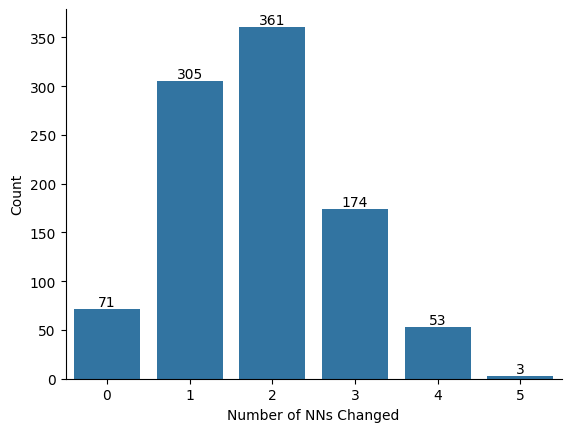

In [764]:
ax = sns.barplot(out, x="Number of NNs Changed", y="Count")
ax.bar_label(ax.containers[0], fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [739]:
df_DAB[(df_DAB['diff_num']==5) & (df_DAB['type']=='Medications')]

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5,diff,diff_num
156,156,13,1,Vasopressin,1515,Medications,Vasopressin,Platelet Count,O2 Flow (additional cannula),Arctic Sun/Alsius Temp #1 C,PH (dipstick),AST,"{'PH (dipstick)', 'O2 Flow (additional cannula...",5


In [740]:
ind = df_DAB[(df_DAB['diff_num']==5) & (df_DAB['type']=='Medications')].index

In [741]:
df_0.iloc[ind, :]

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
156,156,13,1,Vasopressin,1515,Medications,Vasopressin,Digoxin,T High (APRV),Absolute Count - Lymphs,Creatinine (whole blood),Arterial O2 Saturation


In [742]:
df_1.iloc[ind, :]

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
156,156,13,1,Vasopressin,1515,Medications,Vasopressin,Platelet Count,O2 Flow (additional cannula),Arctic Sun/Alsius Temp #1 C,PH (dipstick),AST


In [42]:
print(df_0.iloc[ind, :].feature.tolist())

['Vasopressin']


Dobutamine: A positive inotropic agent that increases the force of heart contractions, improving cardiac output. It is often used in acute decompensated heart failure or cardiogenic shock.

Norepinephrine: A vasopressor that constricts blood vessels, raising blood pressure and maintaining perfusion in cases of severe hypotension or shock associated with heart failure.

Furosemide (Lasix): A loop diuretic used to promote diuresis and reduce fluid overload in acute decompensated heart failure, helping to alleviate pulmonary congestion.

Nitroglycerin: A vasodilator that reduces preload and afterload, easing the workload on the heart. It is used to manage acute heart failure and pulmonary edema.

Milrinone: A phosphodiesterase inhibitor with inotropic and vasodilatory effects, used for short-term management of acute heart failure when other interventions are insufficient.

Vasopressin: May be used as an adjunct in vasodilatory shock associated with heart failure to support blood pressure.

In [765]:
df_split = pd.read_csv('/h/chloexq/los-prediction/pipeline/data/labels_split.csv')
train_l = len(df_split[df_split['split']=='train'])
val_l = len(df_split[df_split['split']=='val'])
test_l = len(df_split[df_split['split']=='test'])

In [839]:
data2_dir = '/h/chloexq/los-prediction/pipeline/data/features/'
n_meds = 259
names = ['tokenized_src', 'tokenized_age', 'tokenized_gender', 'tokenized_ethni', 'tokenized_ins', 'tokenized_labels', 'labs', 'meds']
#meds_labels = np.load(data2_dir + 'data/token/'+'meds_labels_5000.npy', allow_pickle=True)
meds_labels = np.load(data2_dir + 'meds_labels_5000.npy', allow_pickle=True)
all_df = []
for i in range(len(names)):
    #df = pd.read_csv(data2_dir + 'data/token/'+names[i]+'_5000.csv', index_col=0)
    df = pd.read_csv(data2_dir + names[i]+'_5000.csv', index_col=0).loc[train_l+val_l:, :]
    all_df.append(df)
tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds = all_df

In [840]:
tokenized_src

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
6690,1,10,12,30,37,38,42,43,47,48,...,2314.0,1945.0,1520.0,1817.0,1843.0,1502.0,2026.0,1658.0,2.0,2207.0
6691,1,13,17,30,38,42,44,45,47,48,...,1781.0,1970.0,1367.0,2.0,2011.0,2024.0,2188.0,1781.0,2175.0,1380.0
6692,1,13,17,30,38,42,44,45,47,48,...,1781.0,1970.0,1367.0,2.0,2011.0,2024.0,2188.0,1781.0,2175.0,1380.0
6693,1,13,17,30,38,42,44,45,47,48,...,1781.0,1970.0,1367.0,2.0,2011.0,2024.0,2188.0,1781.0,2175.0,1380.0
6694,1,13,17,30,38,42,44,45,47,48,...,1781.0,1970.0,1367.0,2.0,2011.0,2024.0,2188.0,1781.0,2175.0,1380.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7691,1,3,22,24,38,42,44,45,46,47,...,1425.0,2285.0,2244.0,2097.0,2255.0,1529.0,1682.0,2115.0,2064.0,1847.0
7692,1,9,14,18,19,27,34,42,47,68,...,1858.0,1397.0,1380.0,2.0,2103.0,1894.0,2011.0,1808.0,1707.0,2198.0
7693,1,6,9,18,27,31,35,37,76,82,...,1970.0,2221.0,2137.0,1591.0,2128.0,1393.0,1789.0,2031.0,1637.0,2145.0
7694,1,9,12,14,22,26,27,48,61,79,...,1858.0,2175.0,1367.0,2.0,1766.0,2299.0,2241.0,1858.0,1970.0,1367.0


In [841]:
med_name = 'Norepinephrine' #'Vasopressin', 'Milrinone', 'ACD-A Citrate (1000ml)'

In [842]:
df_key[df_key['feature'] == med_name]

,df_id,level,feature,emb_id,type
0,2,2,Norepinephrine,1359,Medications
199,2,0,Norepinephrine,1558,Medications
209,2,3,Norepinephrine,1568,Medications
848,2,1,Norepinephrine,2207,Medications


In [843]:
level1_id = df_key[(df_key['feature'] == med_name) & (df_key['level'] == 1)].emb_id.values[0]
level2_id = df_key[(df_key['feature'] == med_name) & (df_key['level'] == 2)].emb_id.values[0]
level3_id = df_key[(df_key['feature'] == med_name) & (df_key['level'] == 3)].emb_id.values[0]

In [621]:
meds_level_0_mask = meds[meds==level1_id].any(axis='columns').values #1635 #1799

In [622]:
ind = meds.loc[meds_level_0_mask, :].index
len(ind)

326

In [623]:
ori_ind = level1_id
replace_ind = [level2_id, level3_id]
df_counterfact = pd.DataFrame()

In [624]:
for setting in tqdm.tqdm(['given_1', 'given_1_pred_2', 'given_1_pred_3']):
    data2_dir = '/h/chloexq/los-prediction/pipeline/data/features/'
    n_meds = 259
    names = ['tokenized_src', 'tokenized_age', 'tokenized_gender', 'tokenized_ethni', 'tokenized_ins', 'tokenized_labels', 'labs', 'meds']
    meds_labels = np.load(data2_dir + 'meds_labels_5000.npy', allow_pickle=True)
    meds_labels = meds_labels[ind]
    all_df = []
    for i in range(len(names)):
        df = pd.read_csv(data2_dir + names[i]+'_5000.csv', index_col=0)
        # subset test set only
        df = df.loc[train_l+val_l:].copy()
        df = df.loc[ind].copy().reset_index().drop(columns='index')
        all_df.append(df)
    tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds = all_df
    if setting == 'given_1_pred_2':
        tokenized_src = tokenized_src.replace({ori_ind: replace_ind[0]})
    elif setting == 'given_1_pred_3':
        tokenized_src = tokenized_src.replace({ori_ind: replace_ind[1]})
    val_data = {"code": tokenized_src.values, 
            "age": tokenized_age.values, 
            "labels": tokenized_labels.values,
            "gender" : tokenized_gender.values, 
            "ethni" : tokenized_ethni.values, 
            "ins" : tokenized_ins.values, 
            "labs": labs.values, 
            "meds": meds.values, 
            "meds_labels": meds_labels, 
            "n_meds": n_meds}
    ValDset = DataLoader(val_data, max_len=512, code='code')
    valload = torch.utils.data.DataLoader(dataset=ValDset, batch_size=16, shuffle=False)
    behrt.to(device)
    behrt.eval()
    output_list = []
    for step, batch in enumerate(valload):
        batch = tuple(t for t in batch)
        input_ids, age_ids, gender_ids, ethni_ids, ins_ids, segment_ids, posi_ids, attMask, labels, labs_ids, meds_ids, _  = batch

        input_ids = input_ids.to(device)
        age_ids = age_ids.to(device)
        gender_ids = gender_ids.to(device)
        ethni_ids = ethni_ids.to(device)
        ins_ids = ins_ids.to(device)
        posi_ids = posi_ids.to(device)
        segment_ids = segment_ids.to(device)
        attMask = attMask.to(device)
        labels = labels.to(device)
        labs_ids = labs_ids.to(device)
        meds_ids = meds_ids.to(device)
    
        logits, _, _ = behrt(input_ids, labs_ids, meds_ids, age_ids, gender_ids, ethni_ids, ins_ids, segment_ids, posi_ids, attention_mask=attMask)
        preds = torch.sigmoid(logits)
        output_list.extend(preds.detach().cpu().numpy().flatten().tolist())
    df_counterfact[setting] = output_list

100%|██████████| 3/3 [00:11<00:00,  3.75s/it]


In [625]:
df_counterfact

,given_1,given_1_pred_2,given_1_pred_3
0,0.852334,0.847319,0.850894
1,0.969657,0.969512,0.969602
2,0.969657,0.969512,0.969602
3,0.969657,0.969512,0.969602
4,0.969657,0.969512,0.969602
...,...,...,...
321,0.965517,0.961400,0.965211
322,0.965517,0.961400,0.965211
323,0.301097,0.094885,0.303512
324,0.052270,0.050916,0.051929


In [626]:
df_counterfact.to_csv('DAB_Oversample_{}_test.csv'.format(med_name))

In [610]:
df_counterfact.mean(0)

given_1           0.659883
given_1_pred_2    0.650434
given_1_pred_3    0.656522
dtype: float64

In [627]:
df_counterfact.mean(0)

given_1           0.700602
given_1_pred_2    0.674998
given_1_pred_3    0.702383
dtype: float64

In [927]:
med_name = 'Norepinephrine' #'Vasopressin' #'Milrinone', 'ACD-A Citrate (1000ml)' #Norepinephrine

In [928]:
print(med_name)

Norepinephrine


In [929]:
df_counterfact_dab = pd.read_csv('DAB_Oversample_{}_test.csv'.format(med_name), index_col=0)

In [930]:
df_counterfact_nodab = pd.read_csv('NO_DAB_Oversample_{}_test.csv'.format(med_name), index_col=0)

In [931]:
df_counterfact_nodab

,given_1,given_1_pred_2,given_1_pred_3
0,0.954314,0.953840,0.954153
1,0.936905,0.936791,0.936926
2,0.936905,0.936791,0.936926
3,0.936905,0.936791,0.936926
4,0.936905,0.936791,0.936926
...,...,...,...
321,0.920717,0.914276,0.919740
322,0.920717,0.914276,0.919740
323,0.024883,0.021400,0.023014
324,0.042648,0.039350,0.040998


In [932]:
df_counterfact_nodab.mean(0)

given_1           0.659883
given_1_pred_2    0.650434
given_1_pred_3    0.656522
dtype: float64

In [933]:
df_counterfact_dab.mean(0)

given_1           0.700602
given_1_pred_2    0.674998
given_1_pred_3    0.702383
dtype: float64

In [934]:
#df_counterfact_nodab['given_1_pred_2'] < df_counterfact_nodab['given_1']

## Given 1 pred 2

In [935]:
sum((df_counterfact_dab['given_1_pred_2'] != df_counterfact_dab['given_1']))

240

In [936]:
sum((df_counterfact_dab['given_1_pred_2'] > df_counterfact_dab['given_1']))

13

In [937]:
sum((df_counterfact_dab['given_1_pred_2'] < df_counterfact_dab['given_1']))

227

In [938]:
sum((df_counterfact_nodab['given_1_pred_2'] != df_counterfact_nodab['given_1']))

240

In [939]:
sum((df_counterfact_nodab['given_1_pred_2'] > df_counterfact_nodab['given_1']))

0

In [940]:
sum((df_counterfact_nodab['given_1_pred_2'] < df_counterfact_nodab['given_1']))

240

In [918]:
((df_counterfact_dab['given_1_pred_2'] < df_counterfact_dab['given_1']) != (df_counterfact_nodab['given_1_pred_2'] < df_counterfact_nodab['given_1'])).sum()

14

(array([0, 1]), [Text(0, 0, 'Baseline'), Text(1, 0, 'Domain Confusion')])

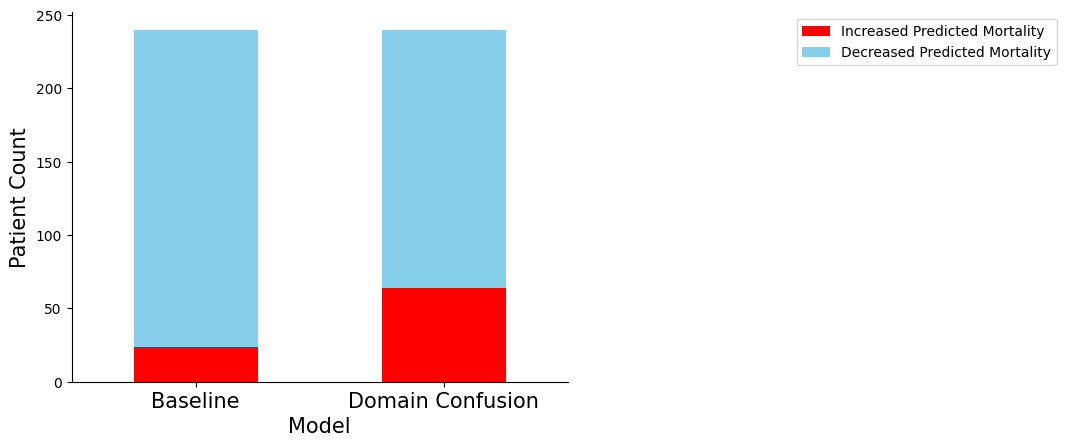

In [919]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

# create DataFrame
df = pd.DataFrame({'Increased Predicted Mortality': [24, 64],
                   'Decreased Predicted Mortality': [216, 176]},
                  index=['Baseline', 'Domain Confusion'])
 
 
# create stacked bar chart for monthly temperatures
ax = df.plot(kind='bar', stacked=True, color=['red', 'skyblue'])
 
# labels for x & y axis
plt.xlabel('Model', fontsize=15)
plt.ylabel('Patient Count', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', bbox_to_anchor=(2, 1), ncol=1)
plt.xticks(rotation=0, fontsize=15)
# title of plot
#plt.title('Monthly Temperatures in a year')

## Given 1 pred 3

In [941]:
sum((df_counterfact_dab['given_1_pred_3'] != df_counterfact_dab['given_1']))

240

In [942]:
sum((df_counterfact_dab['given_1_pred_3'] > df_counterfact_dab['given_1']))

64

In [943]:
sum((df_counterfact_dab['given_1_pred_3'] < df_counterfact_dab['given_1']))

176

In [944]:
sum((df_counterfact_nodab['given_1_pred_3'] != df_counterfact_nodab['given_1']))

240

In [945]:
sum((df_counterfact_nodab['given_1_pred_3'] > df_counterfact_nodab['given_1']))

24

In [946]:
sum((df_counterfact_nodab['given_1_pred_3'] < df_counterfact_nodab['given_1']))

216

### EVALUATION AS STANDALONE MODULE
Below cell shows an exaple of how evaluation module can be used as a standalone module.

evaluation.Loss class can be instantiated and model output and ground truth can be passed to it to obtain results.

In the example below we captured model output and ground truth in a file and used that file to read the data.

In function definition ***loss(prob,truth,logits,False)***

prob -> List of Output predicted probabilities of case being positive

truth -> List of ground truth labels

logits -> List of logits obtained from last fully connected layer before applying softmax.sigmoid function in the model.

In [10]:
if torch.cuda.is_available():
    device='cuda:0'
#device='cpu'
loss=evaluation.Loss(device,acc=True,ppv=True,sensi=True,tnr=True,npv=True,auroc=True,aurocPlot=True,auprc=True,auprcPlot=True,callb=True,callbPlot=True)

In [11]:
logits = pd.read_csv('./data/behrt/DAB_1/behrt_preds.csv', index_col=0, header=None)

In [103]:
prob = torch.sigmoid(torch.tensor(logits.values)).numpy()

In [104]:
truth = pd.read_csv('./data/behrt/DAB_1/behrt_labels.csv', index_col=0, header=None)

In [105]:
truth = truth.values.flatten().tolist()
logits = logits.values.flatten().tolist()
prob = prob.flatten().tolist()

BCE Loss: 1.81
AU-ROC: 0.82
AU-PRC: 0.44
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.61
Recall: 0.24
Specificity: 0.98
NPV: 0.90
ECE: 0.02
MCE: 0.06


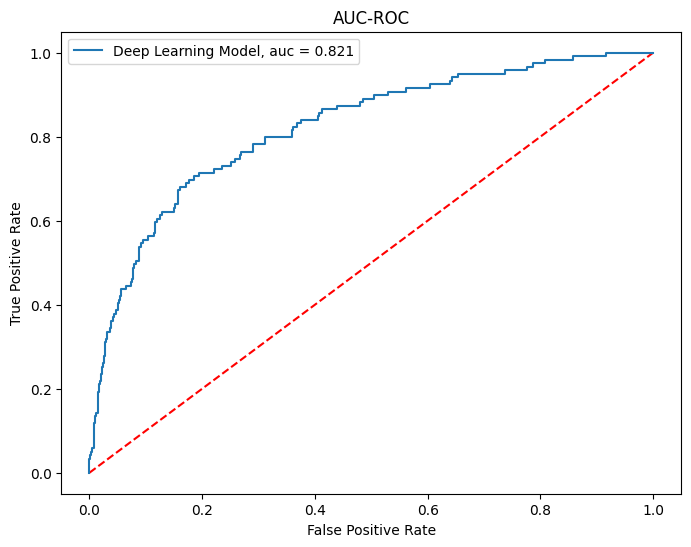

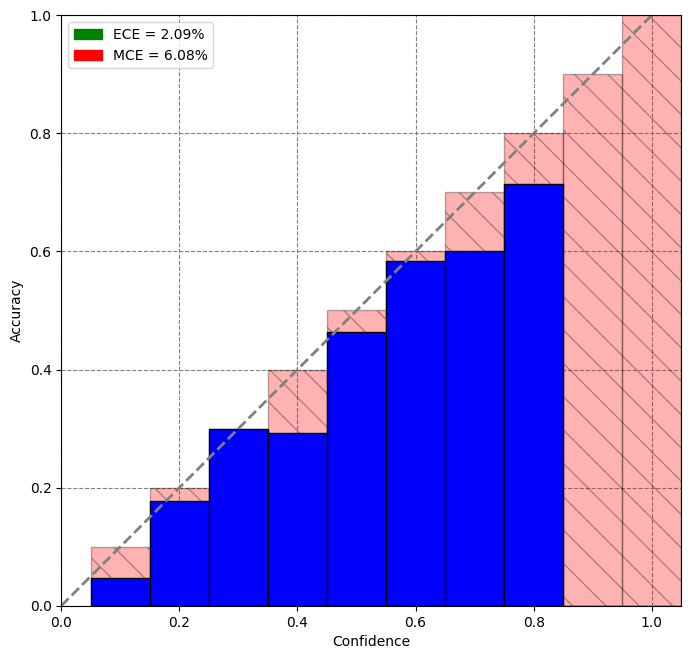

In [106]:
loss(prob,truth,logits,train=False,standalone=True)

In [93]:
output_df = pd.DataFrame()
output_df['Prob'] = prob
output_df['Logits'] = logits
output_df['Labels'] = truth

In [94]:
with open('./data/output/'+'outputDict_NODAB', 'wb') as fp:
    pickle.dump(output_df, fp)

In [74]:
# with open("./data/output/outputDict", 'rb') as fp:
#     outputDict=pickle.load(fp)
# prob=list(outputDict['Prob'])
# truth=list(outputDict['Labels'])
# logits=list(outputDict['Logits'])
# #print(torch.tensor(prob))
# print("======= TESTING ========")
# loss(prob,truth,logits,train=False,standalone=True)


### 11. FAIRNESS EVALUATION
In train and testing step we save output files in **./data/output/** folder.

This file conatins list of demographic variables included in training and testing of the model.

It also contains the ground truth labels and predicted probability for each sample.

We use the above saved data to perform fairness evaluation of the results obtained from model testing.

This module can be used as stand-alone module also.

Please create a file that contains predicted probabilites form the last sigmoid layer in column named **Prob** and
ground truth labels for each sample in column named **Labels**.

In [86]:
#fairness.fairness_evaluation(inputFile='outputDict_DAB1',outputFile='fairnessReport')

### 12. MODEL CALLIBRATION

Please run below cell if you want to callibrate predicted probabilites of the model on test data.
It will use the output saved during the testing of the model.

The file is saved in **./data/output/**.

This module can be used as stand-alone module also.

Please create a file that contain predicted logits form the last fully connected layer in column named **Logits** and <br>ground truth labels for each sample in a column named **Labels**.

BEFORE CALLIBRATION
BCE Loss: 1.81
AU-ROC: 0.82
AU-PRC: 0.44
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.61
Recall: 0.24
Specificity: 0.98
NPV: 0.90
ECE: 0.02
MCE: 0.06
AFTER CALLIBRATION
BCE Loss: 1.67
AU-ROC: 0.82
AU-PRC: 0.44
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.61
Recall: 0.24
Specificity: 0.98
NPV: 0.90
ECE: 0.01
MCE: 0.28


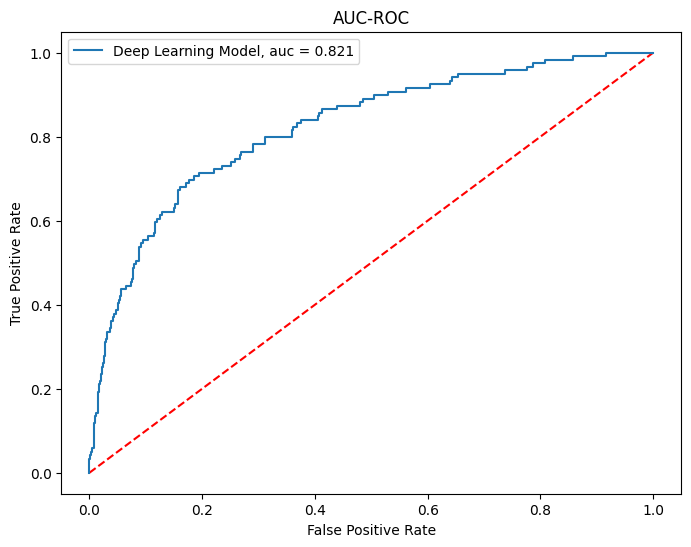

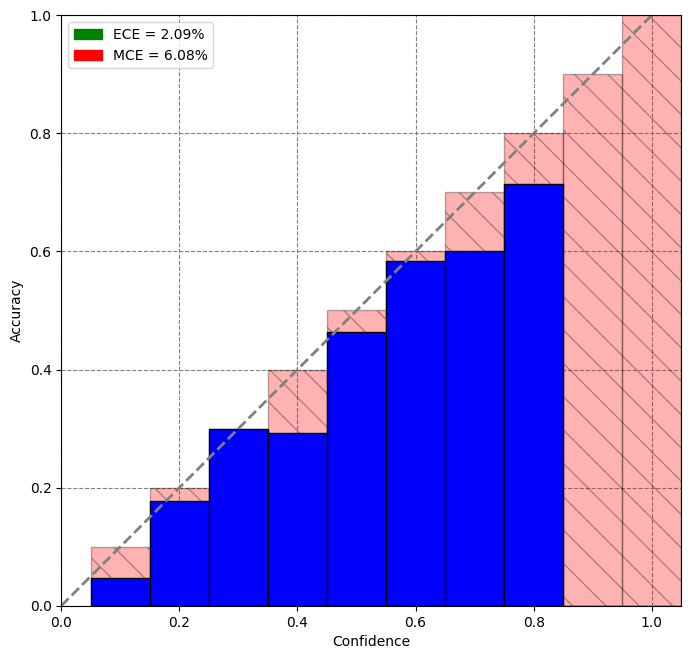

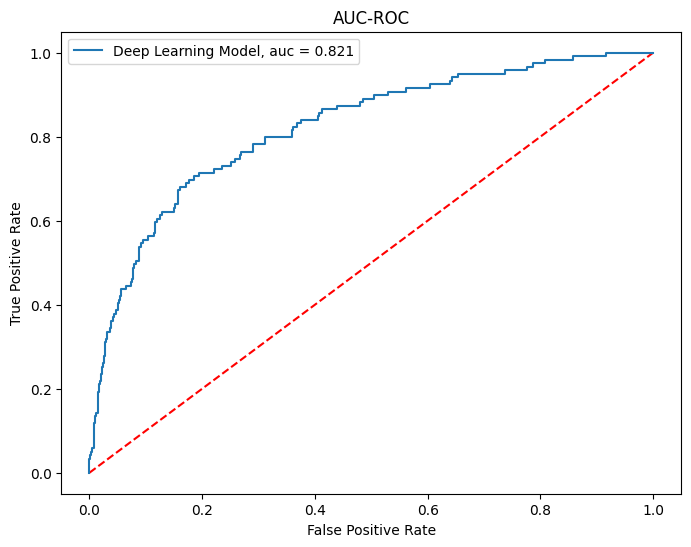

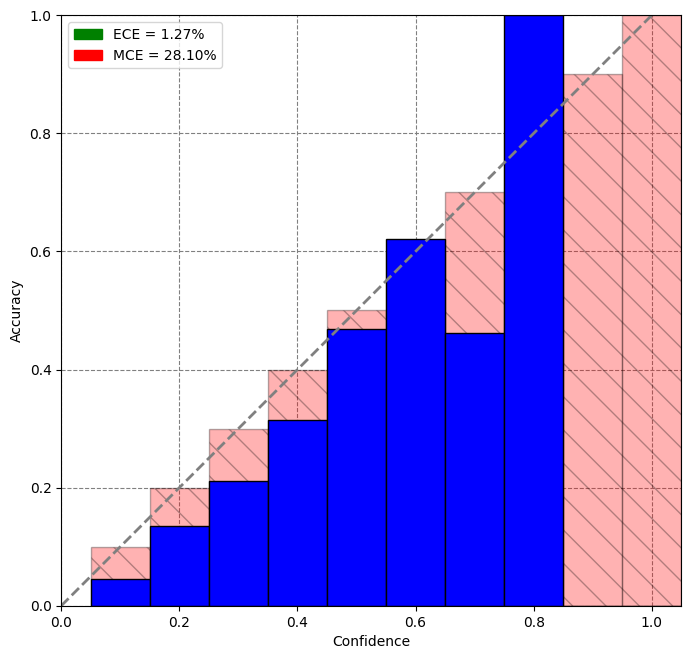

In [107]:
callibrate_output.callibrate(inputFile='outputDict_DAB1',outputFile='callibratedResults')

In [ ]:
Dobutamine: A positive inotropic agent that increases the force of heart contractions, improving cardiac output. It is often used in acute decompensated heart failure or cardiogenic shock.

Norepinephrine: A vasopressor that constricts blood vessels, raising blood pressure and maintaining perfusion in cases of severe hypotension or shock associated with heart failure.

Furosemide (Lasix): A loop diuretic used to promote diuresis and reduce fluid overload in acute decompensated heart failure, helping to alleviate pulmonary congestion.

Nitroglycerin: A vasodilator that reduces preload and afterload, easing the workload on the heart. It is used to manage acute heart failure and pulmonary edema.

Milrinone: A phosphodiesterase inhibitor with inotropic and vasodilatory effects, used for short-term management of acute heart failure when other interventions are insufficient.

Vasopressin: May be used as an adjunct in vasodilatory shock associated with heart failure to support blood pressure.